# Analysis of outwardly depressive mood on social media

Use of Natural Language Processing on posts made on Twitter and Reddit to predict depressive thoughts.

---

This notebook is written to be run both locally or on Google Colab.

## Setup for local run

- Download the root file as is.
- Install packages

In [4]:
# ! pip install pandas
# ! pip install numpy
# ! pip install nltk
# ! pip install pickle
# ! pip install keras
# ! pip install tqdm
# ! pip install dask
# ! pip install seaborn
# ! pip install wordcloud

## Setup for Google Colab

- Download this notebook and upload onto Google Colab
- Download the zip files (within /input) and upload into root directory of your Google Drive.

*You may download the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) directly from the source and replace the provided one (within /input). No edits were made to the data.*

In [52]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import math

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

from re import sub
from time import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from dask.diagnostics import ProgressBar
import dask.dataframe as dd
ProgressBar().register()

from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JunKai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def runLocally():

    import shutil
    import os
    import tensorflow as tf

    print("Running locally...")

    path = './build'

    if not os.path.isdir(path):
        for x in os.listdir('./input'):
            shutil.unpack_archive(f'./input/{x}', path)
            print(f"Extracted {x} into '{path}' directory")
    else:
        print(f"{path} directory already exists. Skipping extracting of zip files.")

    gpuCount = len(tf.config.list_physical_devices('GPU'))
    
    if gpuCount > 0:

        print(f"{gpuCount} GPUs detected.")

        if tf.test.is_built_with_cuda():
            print(f"Tensorflow has CUDA support.")

        if not tf.test.is_built_with_cuda():
            print("Tensorflow doesn't have CUDA support.")
    else:
        print("No GPUs detected on local device.")

    return path

def runOnColab():

    from google.colab import drive
    
    print("Running on Google Colab")
    
    drive.mount('/content/drive')

    !unzip "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip"
    !unzip "/content/drive/MyDrive/scrapped_posts.zip"

    return '/content'
    
directory = runLocally()

Running locally...
./build directory already exists. Skipping extracting of zip files.
1 GPUs detected.
Tensorflow has CUDA support.


# Loading model from pre-trained

In [7]:
def loadModel(pathToModel, pathToPKL):
    with open(pathToPKL, 'rb') as f:
        tokeniser = pickle.load(f)
    return load_model(pathToModel), tokeniser

model, tokeniser = loadModel("./model.h5", "./tokenizer.pkl")

In [8]:
def removeInvalidRedditPost(df):
    df = df[df.Body.notna()]
    df = df[df.Author != "[removed]"]
    df = df[df.Body != "[removed]"]
    df = df[df.Author != "[deleted]"]
    df = df[df.Body != "[deleted]"]

    return df

def standardiseRedditDF(dff, sentimentValue=None):

    dff = removeInvalidRedditPost(dff)
    dff.rename(columns={'Author': 'user_id', 'Post_iD': 'id', 'Publish_date':'date', 'Body':'text'}, inplace=True)
    dff['text'] = dff['Title'].str.cat(dff['text'], sep=" ")
    dff = dff.drop(columns=['Score', 'Total_no_of_comments', 'Link', 'Subreddit', 'Title'])
    
    if sentimentValue != None:
        dff['sentiment'] = sentimentValue

    return dff

def preprocess(text):
  
    text = str(text).lower()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = "@[^\s]+" 
    alphaPattern      = "[^a-zA-Z0-9]"

    text = sub(urlPattern, ' URL', text).strip()
    text = sub(userPattern, ' USER', text).strip()
    text = sub(alphaPattern, ' ', text).strip()
    
    stopWords = stopwords.words("english")
    tokens = list(filter(lambda x: x not in stopWords, text.split()))

    return " ".join(tokens)

def parellelPreProcess(df):
    ddf = dd.from_pandas(df, npartitions=4)
    ddf["text"] = ddf["text"].map(lambda x: preprocess(x), meta=('result', str))
    return ddf.compute()

def sentimentFromScore(score):
  score = float(score)
  label = 'Neutral'
  if score <= 0.35:
      label = 'Negative'
  elif score >= 0.65:
      label = 'Positive'

  return label

def predict(text, wantsTime=False):
  if wantsTime: 
      start_at = time()
  
  text = str(text)
  score = model.predict(pad_sequences(tokeniser.texts_to_sequences([text]), maxlen=300))

  result = {"label": sentimentFromScore(score), 
            "score": score}
  
  if wantsTime: 
      result["elapsedTime"] = time() - start_at

  return result

# Analysis on uncategorised subreddits

## Preparing data 

In [24]:
def processSubreddit(file, count = 0):
    df4 = pd.read_csv(f"{directory}/{file}")
    df4 = standardiseRedditDF(df4)
    df4 = parellelPreProcess(df4)

    if count > 0:
        if count <= len(df4.index):
            df4 = df4.head(count)
        
    ddf = dd.from_pandas(df4, npartitions=4)
    ddf["sentimentScore"] = ddf["text"].map(lambda x: float(predict(x)['score']), meta=('result', float))
    ddf["sentiment"] = ddf["sentimentScore"].map(lambda x: sentimentFromScore(x), meta=('result', str))
    df4 = ddf.compute()
    
    return df4

teenagersDF = processSubreddit('teenagers.csv', 10000)
teenagersDF.head()

[########################################] | 100% Completed | 15.3s
[########################################] | 100% Completed |  4min 26.1s


,id,user_id,text,date,sentimentScore,sentiment
1,tif34g,SnooCrickets5781,bruh people push death penalty women got abort...,2022-03-20 06:37:17,0.118917,Negative
2,tif2xz,Axehead-245,wish felt loved cut feel better trigger warnin...,2022-03-20 06:36:55,0.000251,Negative
4,tif2p3,AutisticOutlaw,girls boys ask enby answer non binary version ...,2022-03-20 06:36:23,0.746668,Positive
8,tif1mi,el-chapin-supreme,comment letter give song starting letter x q z...,2022-03-20 06:34:11,0.503618,Neutral
10,tif151,Gigachad-1,boys guess day today chest day,2022-03-20 06:33:14,0.127549,Negative


## Analysis

In [85]:
distinguishingZone = 0.35

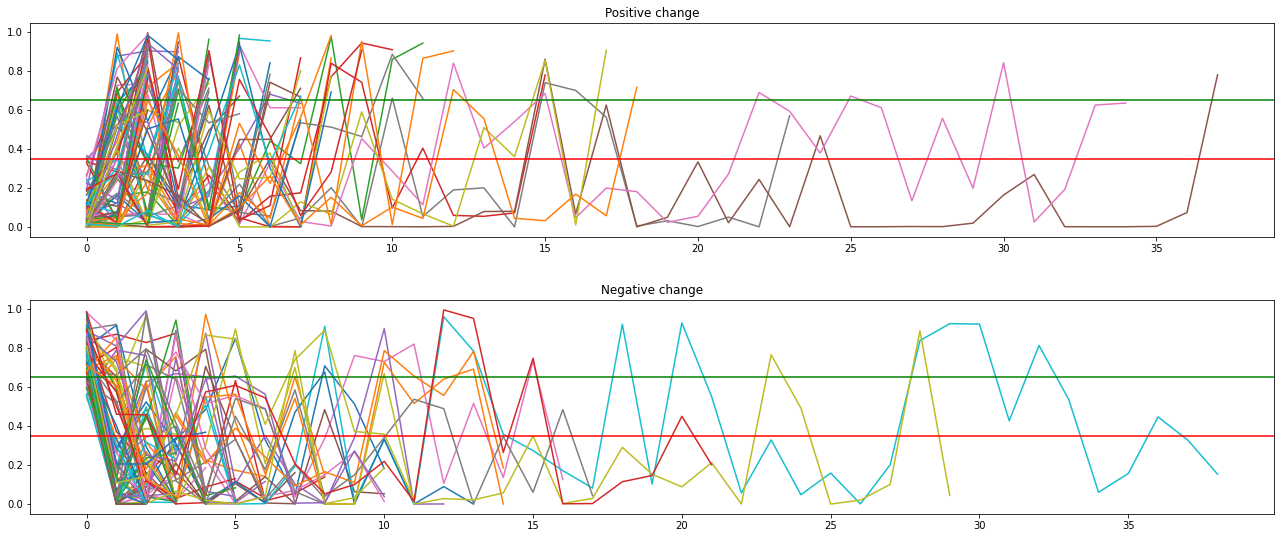

In [86]:
def frequentPosterDF(df):
    
    resultDF = df.groupby('user_id').filter(lambda x : len(x['user_id']) >= 3)

    return resultDF

def changeOfSentimentOverPosts(df, subset = 0):
    
    fig, axs = plt.subplots(2)
    fig.tight_layout()

    axs[0].set_title(f"Positive change")
    axs[1].set_title(f"Negative change")

    df = frequentPosterDF(df)

    names = df.user_id.unique()
    
    if subset > 0:
        if subset <= len(names):
            random.shuffle(names)
            names = names[0:subset]
    
    for name in names:
        singleUserDF = df[df["user_id"] == name].sort_values("date")
        singleUserDF = singleUserDF.reset_index(drop=True)

        diff = singleUserDF['sentimentScore'].iat[-1] - singleUserDF['sentimentScore'].iat[0]

        if diff >= distinguishingZone*1.5:
            singleUserDF.plot(y='sentimentScore', kind='line', figsize=(20,8), ax=axs[0], legend=False)
        elif diff <= -distinguishingZone*1.5:
            singleUserDF.plot(y='sentimentScore', kind='line', figsize=(20,8), ax=axs[1], legend=False)
    
    for x in range(2):
        axs[x].axhline(y=1-distinguishingZone, color='g', linestyle='-')
        axs[x].axhline(y=distinguishingZone, color='r', linestyle='-')
        
    plt.show()

changeOfSentimentOverPosts(teenagersDF)

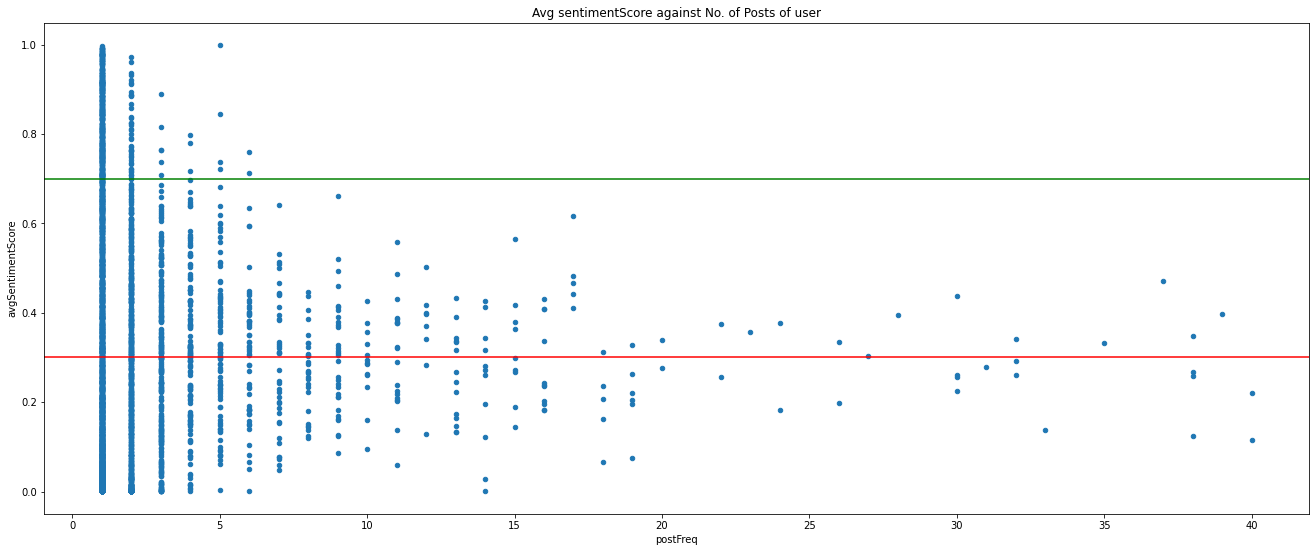

In [45]:
def removeOutliersPostFreq(df):

    minPostFreqDF = df.groupby('postFreq').filter(lambda x : len(x['postFreq']) >= 2)
    highest = minPostFreqDF['postFreq'].max()

    df = df[df['postFreq'] <= highest]

    return df

def avgSentimentScoreOverPostingFreq(df, subset=0):
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    axs.set_title(f"Avg sentimentScore against No. of Posts of user")
    
    names = df.user_id.unique()

    if subset > 0:
        if subset <= len(names):
            random.shuffle(names)
            names = names[0:subset]
    
    tempdf = pd.DataFrame()
    tempdf['user_id'] = pd.DataFrame(names)
    
    tempListMean = []
    tempListCount = []

    for name in names:
        tempListMean.append(df[df['user_id'] == name]['sentimentScore'].mean())
        tempListCount.append(len(df[df['user_id'] == name].index))
    
    tempdf['avgSentimentScore'] = pd.DataFrame(tempListMean)
    tempdf['postFreq'] = pd.DataFrame(tempListCount)
    tempdf = removeOutliersPostFreq(tempdf)
    
    tempdf.plot(x='postFreq', y='avgSentimentScore', kind='scatter', figsize=(20,8), ax=axs)
    plt.axhline(y=1-distinguishingZone, color='g', linestyle='-')
    plt.axhline(y=distinguishingZone, color='r', linestyle='-')
        
    plt.show()

avgSentimentScoreOverPostingFreq(teenagersDF)

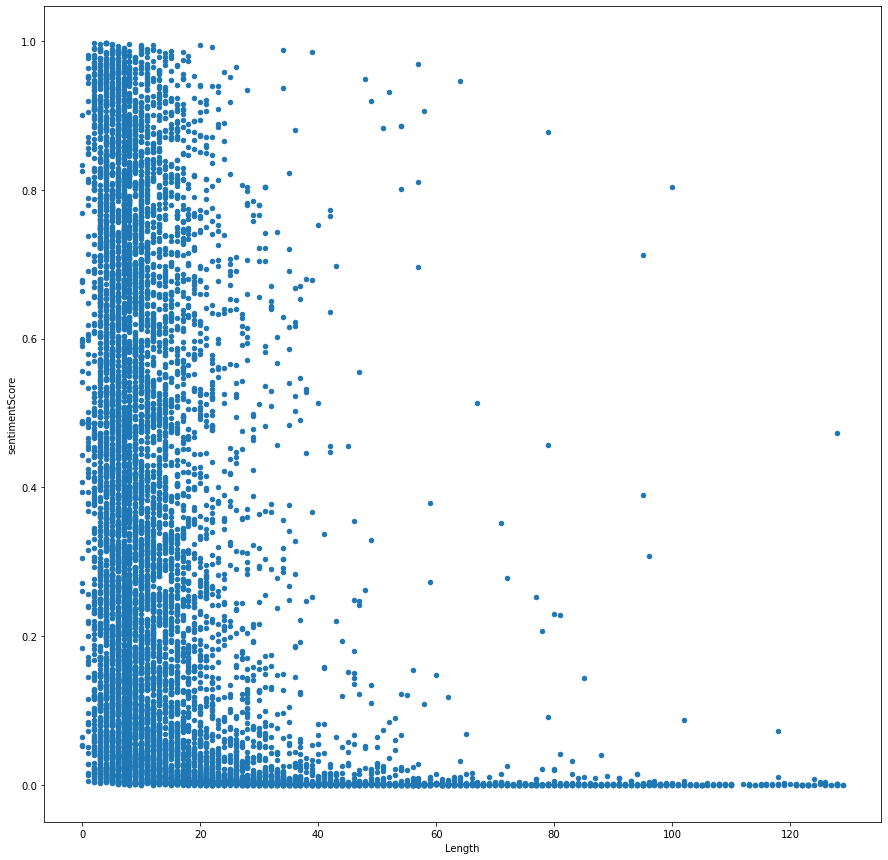

In [10]:
def textCountToSentiment(df):
  #Get count of text body
  df['Length'] = df['text'].str.count(' ') 
  #Remove outliers
  q = df["Length"].quantile(0.98)
  df = df[df["Length"] < q]
  df.plot.scatter(x = 'Length', y = 'sentimentScore', figsize=(15,15))

textCountToSentiment(teenagersDF)

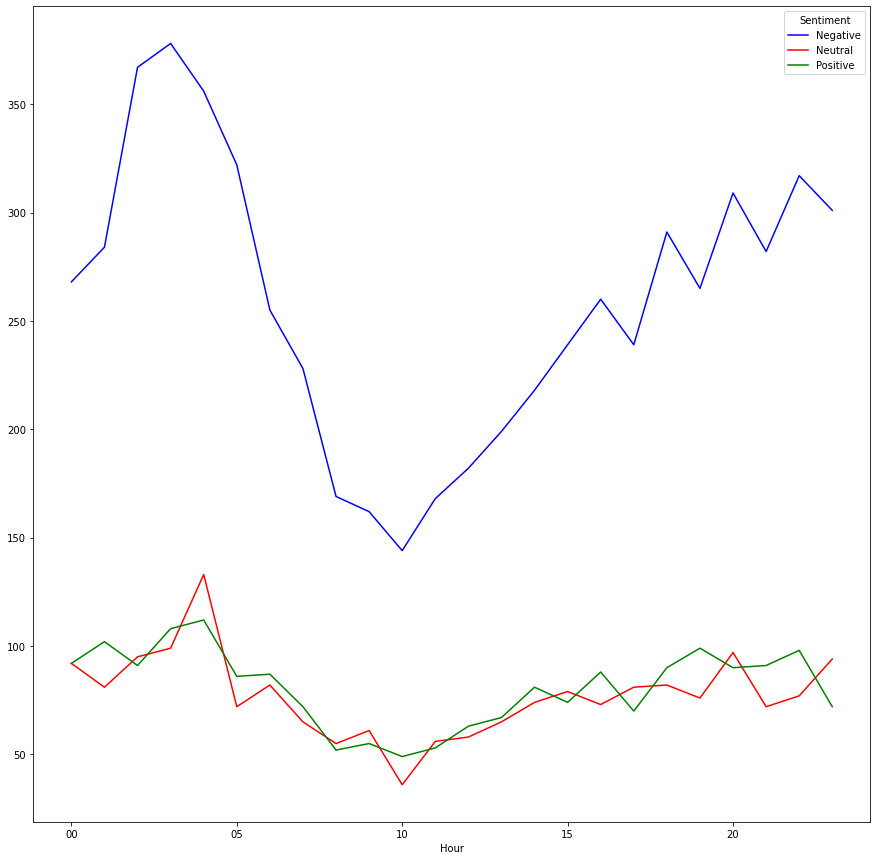

In [11]:
def sentimentToHour(df):
  df['daytime'] = pd.to_datetime(df['date'])
  df['daytime'] = df['daytime'].dt.strftime('%H')
  #negatives = df.loc[df['sentiment'] == 'Negative']
  #df.plot.scatter(x = 'daytime', y = 'sentimentScore')
  negCount = df.groupby(['daytime', 'sentiment']).size()
  countFrame = pd.DataFrame(negCount).reset_index()
  countFrame.columns = ['Hour', 'Sentiment', 'PostCount']
  df2 = countFrame.pivot(index='Hour', columns='Sentiment', values='PostCount')
  color_dict = {'Positive': '#008000', 'Negative': '#0000FF', 'Neutral': '#FF0000'}
  df2.plot(color = [color_dict.get(x, '#333333') for x in df2.columns], figsize = (15,15))
  plt.show

sentimentToHour(teenagersDF)